# Summary

In [1]:
%load_ext autoreload

import os
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.ssmutils as ssmutils
import flygenvectors.data as dataUtils

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [3]:
# options
# expt_id = '190424_f3'  # (run+feed)
# expt_id = '180824_f3r1'
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

dlc_array = dataUtils.load_dlc_from_csv(expt_id)
print('Loaded data from experiment %s' % expt_id)
print('n time points: %i' % dlc_array.shape[0])

/home/mattw/Dropbox/github/flygenvectors/flygenvectors/data.py:98: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dlc = genfromtxt(file_path, delimiter=',', dtype=None)


Loaded data from experiment 2019_07_01_fly2
n time points: 192980


### preprocess data - split into training/testing sets

In [4]:
# subtract off mean and divide by variance across all labels
xs = dlc_array[:, 0::3]
ys = dlc_array[:, 1::3]
x_mean = np.mean(xs, axis=0)
y_mean = np.mean(ys, axis=0)
overall_std = np.mean(np.concatenate([xs, ys], axis=0))
dlc_by_coord = dict(
    x=(xs - x_mean) / overall_std,
    y=(ys - y_mean) / overall_std,
#     x=zscore(xs, axis=0),
#     y=zscore(ys, axis=0),
    l=dlc_array[:, 2::3])
del xs
del ys
del dlc_array

# clean up single outliers
old_likelihoods = np.copy(dlc_by_coord['l'])
dlc_by_coord = dataUtils.clean_dlc_labels(dlc_by_coord, thresh=0.8)
print('linearly interpolated %i labels' % 
      np.sum(((old_likelihoods-dlc_by_coord['l']) != 0) * 1.0))
del old_likelihoods
dlc_array = np.concatenate([dlc_by_coord['x'], dlc_by_coord['y']], axis=1)

linearly interpolated 7687 labels


### check outliers

In [5]:
# # plot dlc labels/likelihoods over time
# slc = (1820, 1840)
# plot_diffs = False

# plt.figure(figsize=(12, 10))

# plt.subplot(311)
# plt.plot(np.arange(slc[0], slc[1]), dlc_by_coord['l'][slice(*slc), :])
# plt.title('likelihoods')

# plt.subplot(312)
# coord = 'x'
# behavior = 4* dlc_by_coord[coord] / np.max(np.abs(dlc_by_coord[coord])) + \
#     np.arange(dlc_by_coord[coord].shape[1])
# if plot_diffs:
#     behavior = np.concatenate(
#         [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
# plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
# plt.title('%s coords' % coord)

# plt.subplot(313)
# coord = 'y'
# behavior = 4* dlc_by_coord[coord] / np.max(np.abs(dlc_by_coord[coord])) + \
#     np.arange(dlc_by_coord[coord].shape[1])
# if plot_diffs:
#     behavior = np.concatenate(
#         [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
# plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
# plt.title('%s coords' % coord)

# plt.xlabel('Time (bins)')
# plt.tight_layout()
# plt.show()

### extract bad likelihood runs

In [8]:
# %autoreload 2
# import flygenvectors.ssmutils as ssmutils
# get runs with high likelihoods
bad_indxs_list = ssmutils.extract_high_likelihood_runs(
    dlc_by_coord['l'], l_thresh=0.8, min_length=10, max_length=np.inf, 
    comparison='<=', dims='any')
# place in single array
bad_indxs = np.full(shape=(dlc_by_coord['l'].shape[0], 1), fill_value=False)
for bi in bad_indxs_list:
    bad_indxs[bi] = True
print('removed %i low-likelihood time points' % np.sum(bad_indxs * 1.0))

removed 16086 low-likelihood time points


### split into train/test trials

In [9]:
# %autoreload 2
# import flygenvectors.ssmutils as ssmutils

# get runs with high likelihoods
bad_indxs = None
indxs = ssmutils.extract_high_likelihood_runs(
    dlc_by_coord['l'], l_thresh=0.0, min_length=100, max_length=500, skip_indxs=bad_indxs)

# split runs into train/test
indxs_dict = ssmutils.split_runs(indxs, ['train', 'test', 'val'], [5, 0, 1])

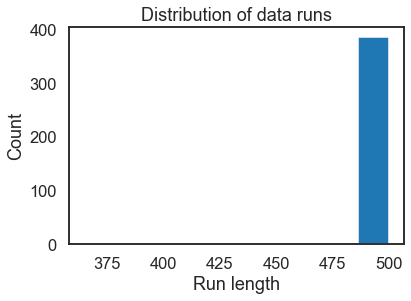

train indices: 161365
test indices: 0
val indices: 32000


In [10]:
# plot distribution of run lengths
import matplotlib.pyplot as plt
plt.figure()
plt.hist([len(i) for i in indxs])
plt.xlabel('Run length')
plt.ylabel('Count')
plt.title('Distribution of data runs')
plt.show()

for dtype in ['train', 'test', 'val']:
    print('%s indices: %i' % (dtype, np.sum([len(i) for i in indxs_dict[dtype]])))

In [11]:
# split data into train/test using indices split above
dlc_dict = {dtype: [] for dtype in indxs_dict.keys()}
for dtype, dindxs in indxs_dict.items():
    for dindx in dindxs:
        dlc_dict[dtype].append(dlc_array[dindx, :])

# 2. Fit dynamics

### ARHMM - how many discrete states?

In [81]:
# %autoreload 2
# import flygenvectors.ssmutils as ssmutils

n_states = [6, 9, 12, 15, 18]
D = dlc_dict['train'][0].shape[1]
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
#     'arhmm-s2': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e2},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-s4-1': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e4},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
    'arhmm-s4-3': {
        'transitions': 'sticky', 
        'transition_kwargs': {'kappa': 1e4},
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
    'arhmm-s4-5': {
        'transitions': 'sticky', 
        'transition_kwargs': {'kappa': 1e4},
        'observations': 'ar',
        'observation_kwargs': {'lags': 5}},
#     'arhmm-s6': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e6},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-s8': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e8},
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
    'arhmm-3': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
    'arhmm-5': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 5}},
#     'arhmm-7': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 7}},
#     'arhmm-r': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-r-3': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-r-5': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-ro': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-ro-3': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-ro-5': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
}

fit_kwargs = {
    'save': True,
    'load_if_exists': True,
    'expt_id': expt_id,
    'model_dir': 'dlc-arhmm',
    'save_dir': None}

all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
#     if model_name in all_results and len(all_results[model_name] == n_states):
#         continue
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = ssmutils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=dlc_dict['train'], data_val=dlc_dict['val'],
            data_test=dlc_dict['test'], fit_kwargs=fit_kwargs)
    all_results[model_name] = model_results

Fitting arhmm-s4-3 with 6 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_3-lags_K=06_kappa=1e+04.pkl
Fitting arhmm-s4-3 with 9 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_3-lags_K=09_kappa=1e+04.pkl
Fitting arhmm-s4-3 with 12 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_3-lags_K=12_kappa=1e+04.pkl
Fitting arhmm-s4-3 with 15 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_3-lags_K=15_kappa=1e+04.pkl
Fitting arhmm-s4-3 with 18 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_3-lags_K=18_kappa=1e+04.pkl
Fitting arhmm-s4-5 with 6 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_5-lags_K=06_kappa=1e+04.pkl
Fitting arhmm-s4-5 with 9 states
loading model from /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm/hmm_sticky_ar_5-lags_K=09_kappa

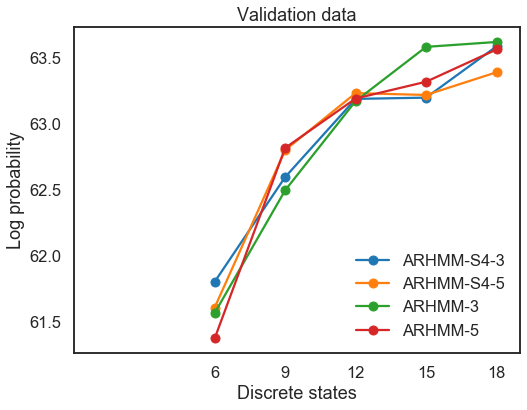

In [82]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_dict['val']]))
plt.legend(loc='lower right', frameon=False)

In [14]:
# model_name = 'arhmm'
# K = 4
# arhmm = all_results[model_name][K]['model']

# # get most likely states
# states_all = arhmm.most_likely_states(data_dlc)
# # get probability of states


# 3. Probe learned dynamics

In [88]:
model_name = 'arhmm-s4-5'
K = 9
dtype = 'train'
arhmm = all_results[model_name][K]['model']

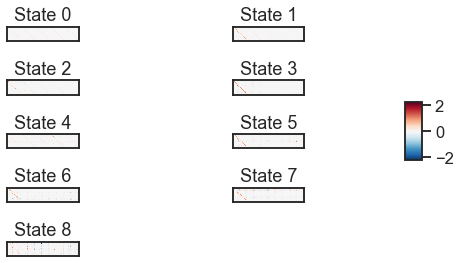

In [84]:
# %autoreload 2
# import flygenvectors.plotting as plotting
fig = plotting.plot_dynamics_matrices(arhmm, deridge=False)

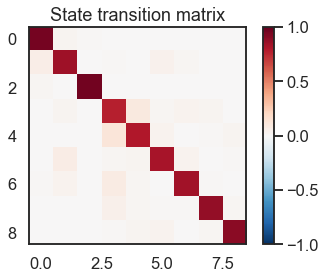

In [89]:
# plot state transition matrix
trans = np.copy(arhmm.transitions.transition_matrix)
deridge = False
if deridge:
    n_states = trans.shape[0]
    for i in range(n_states):
        trans[i, i] = np.nan
    clim = np.nanmax(np.abs(trans))
else:
    clim = 1
plt.figure()
plt.imshow(trans, clim=[-clim, clim], cmap='RdBu_r')
plt.colorbar()
plt.title('State transition matrix')
plt.show()

### find multiple snippets of validation data for each state

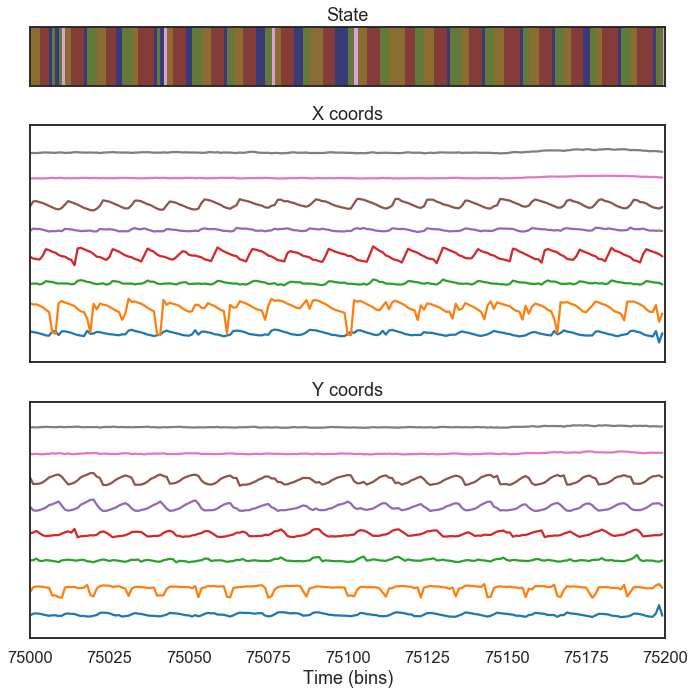

In [90]:
# infer all states and plot dlc lablels
states_ = arhmm.most_likely_states(dlc_array)

slc = (75000, 75200)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_by_coord, state_probs=None, states=states_, slc=slc)

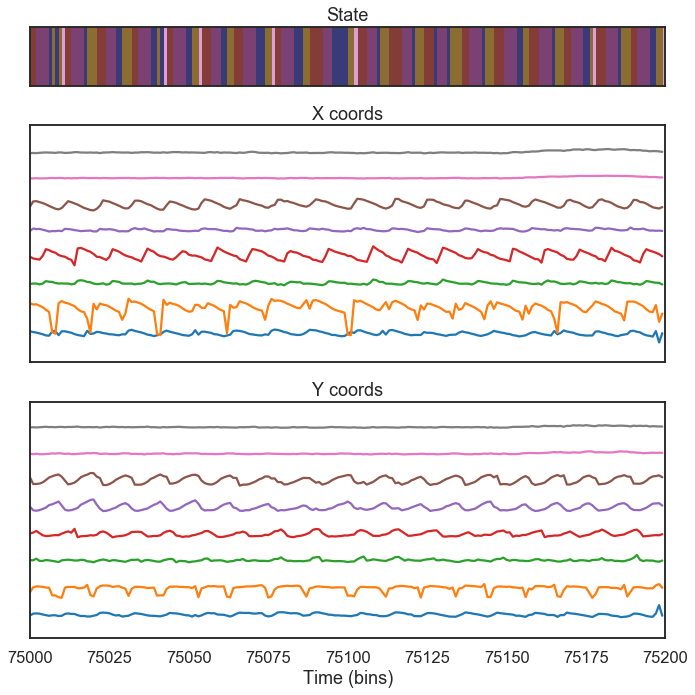

In [87]:
# infer all states and plot dlc lablels
states_ = arhmm.most_likely_states(dlc_array)

slc = (75000, 75200)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_by_coord, state_probs=None, states=states_, slc=slc)

In [92]:
# get most likely states
states_all = [arhmm.most_likely_states(d) for d in dlc_dict[dtype]]

# collect all state snippets
indx_snippets = ssmutils.extract_state_runs(states_all, indxs_dict[dtype], min_length=2)

# get dlc labels
dlc_snippets = [{'x': [], 'y': []} for _ in range(K)]
state_lengths = [[] for _ in range(K)]
for k, k_indxs in enumerate(indx_snippets):
    for k_indx in k_indxs:
        state_lengths[k].append(len(k_indx))
        for coord in ['x', 'y']:
            dlc_snippets[k][coord].append(dlc_by_coord[coord][k_indx])        
state_lengths = [np.array(state_lengths[k]) for k in range(K)]

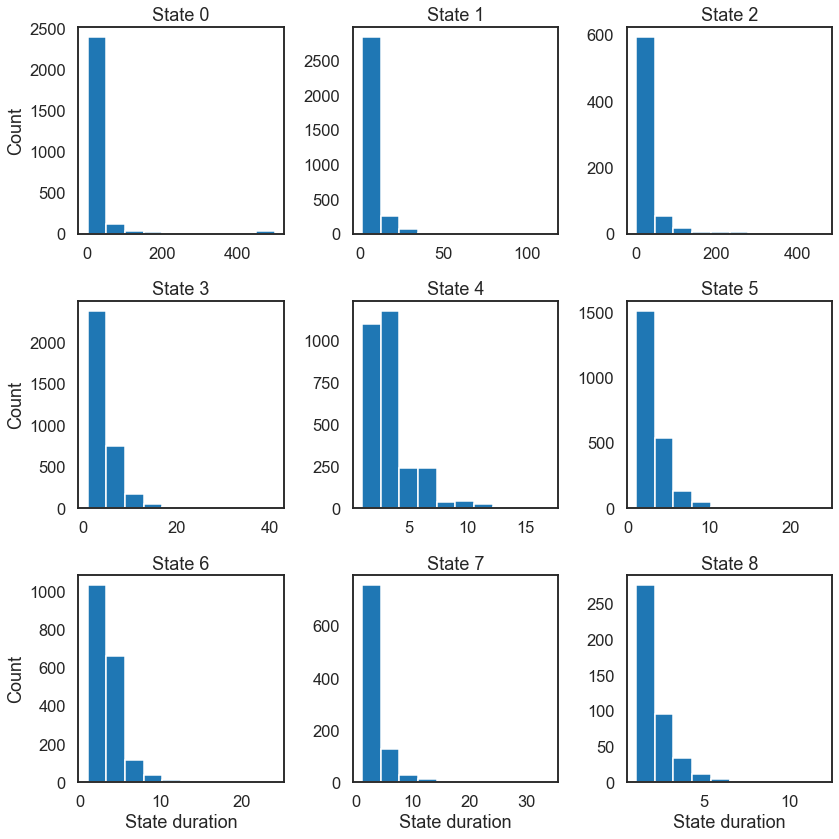

In [93]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

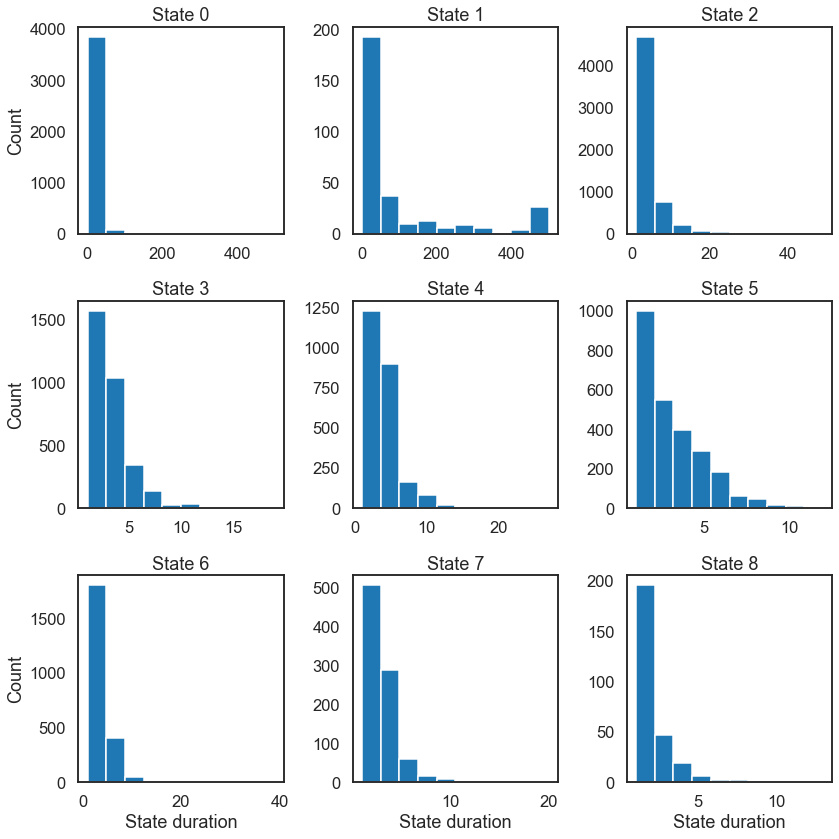

In [19]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

### check for state consistency across lags

In [54]:
K = 12
dtype = 'train'
lags = [1, 2, 3, 5]
states_ = {l:None for l in lags}

for lag in lags:
    if lag == 1:
        model_name = 'arhmm'
    else:
        model_name = str('arhmm-%i' % lag)
    arhmm = all_results[model_name][K]['model']
    states_[lag] = arhmm.most_likely_states(dlc_array)

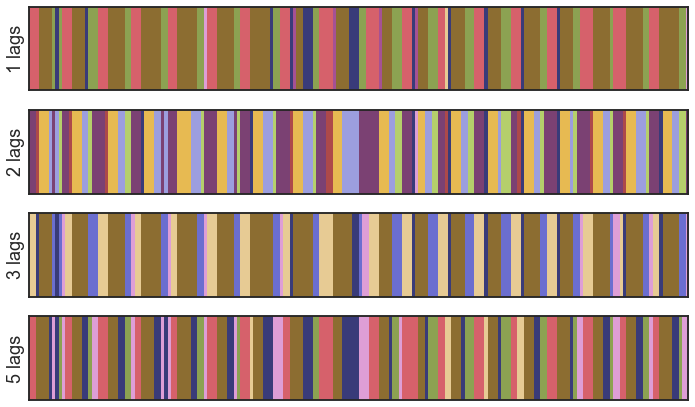

In [67]:
slc = (75000, 75200)

fig, axes = plt.subplots(
    len(lags), 1, figsize=(10, 1.5 * len(lags)),
    gridspec_kw={'height_ratios': [1 / len(lags)] * len(lags)})

for i, l in enumerate(lags):
    axes[i].imshow(states_[l][None, slice(*slc)], aspect='auto', cmap='tab20b')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylabel('%i lags' % l)
plt.tight_layout()
plt.show()

In [20]:
# fig = plotting.make_syllable_plots(dlc_snippets, max_snippets=5, max_t=100, coord='y')

# 4. Make syllable videos

In [57]:
video = dataUtils.load_video(expt_id)

In [94]:
# %autoreload 2
# import flygenvectors.plotting as plotting
K = 9
n_lags = 5
model_name = str('arhmm-s4-%i' % n_lags) if n_lags > 1 else 'arhmm'
dtype = 'train'
arhmm = all_results[model_name][K]['model']
states_all = [arhmm.most_likely_states(d) for d in dlc_dict[dtype]]

processing syllable 1/9
processing syllable 2/9
processing syllable 3/9
processing syllable 4/9
processing syllable 5/9
processing syllable 6/9
processing syllable 7/9
processing syllable 8/9
processing syllable 9/9
creating animation...done
saving video to /home/mattw/results/fly/2019_07_01_fly2/5-lags_K=09_min-3_train_s4.mp4...done


<Figure size 432x288 with 0 Axes>

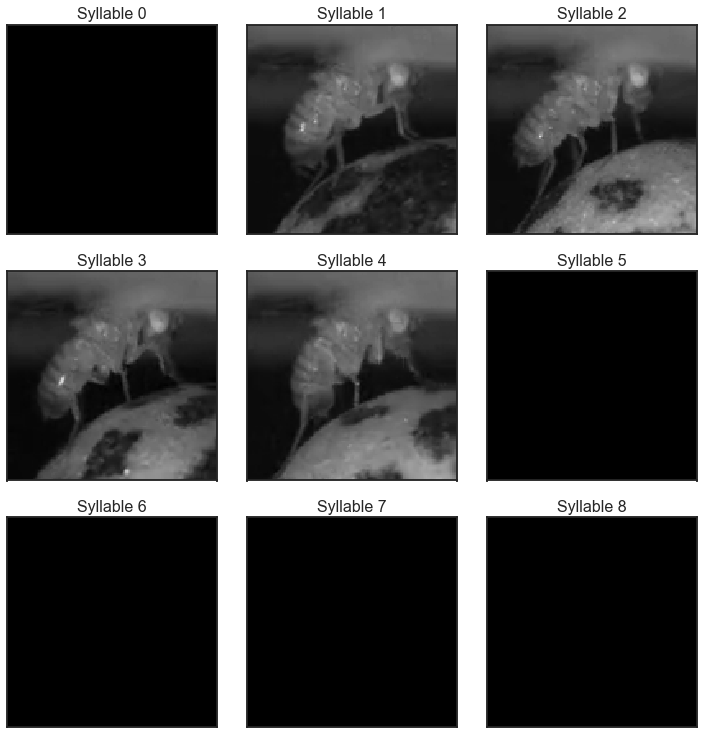

In [95]:
save_file = str('/home/mattw/results/fly/%s/%i-lags_K=%02i_min-3_train_s4.mp4' % (expt_id, n_lags, K))
plotting.make_syllable_movie(
    save_file, states_all, video, indxs_dict[dtype], single_state=None,
    min_threshold=3, n_pre_frames=0, n_buffer=10)